# Analyse channel 1 - 4
Here I will analyse the data of channel 1 - 4 from Alsdorf

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data

plot_save=False #True False
fast_calc=True #True False

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #at the moment everything is imported with pickle

# TO DO
# andere kalibrationsmethoden offenes ende --> Literatur lesen
# knick in dämpfung noch bearbeiten
# Vergleich mit anderen Kanälen systematisch machen

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# pandas version: 1.2.3
# pickle version: 4.0

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [6]:
# Load pickle Data

#this variable only contains every 10s row, if using all data it would be over 2Gb.
if path_to_my_database == r"..\Alsdorf\Daten\my_database":
    data_ch14_constshifted = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted")
else:
    data_ch14_constshifted = read_pickle("data_ch1-4_processed_constshifted")

if fast_calc:
    for chan in ["1","2","3","4"]:
        data_ch14_constshifted[chan] = data_ch14_constshifted[chan][::10] #only use every 10th row

# final shaft temp old cable
shaft={}
for chan in ["1","2","3","4"]:
    shaft[chan] = read_pickle(path_to_my_database + f"\\shaft_final_temperature\\old_cable\\pickle\\Schacht_chan_{chan}")

# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
path_to_my_database_pickle = path_to_my_database + r"\shaft_final_temperature\egrt_cable\pickle"
Schacht_7and8_down = read_pickle(path_to_my_database_pickle + filename)

# Import TLogger
Im Moment sind im PT100 Datensatz alle Daten die ich habe. D.h. meine alten PT100 um 1.5 °C korigiert, ein paar Daten von Solexperts und die neuen PT1000 Daten.

In [7]:
# read csv
# Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

#read_pickle
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

watertank_T_range_min = df_Tlogger_PT100.index.min()
watertank_T_range_max = df_Tlogger_PT100.index.max()

df_Tlogger_PT100

,Channel1-Watertank_PT100,Channel2-Air,Channel1-PT100_rolling_mean
2021-06-07 12:12:40,23.4,25.8,23.5
2021-06-07 12:13:40,23.5,25.4,23.5
2021-06-07 12:14:40,23.4,25.2,23.5
2021-06-07 12:15:40,23.5,24.9,23.5
2021-06-07 12:16:40,23.5,24.8,23.5
...,...,...,...
2021-08-09 10:28:14,20.6,NaN,20.6
2021-08-09 10:31:14,20.6,NaN,20.6
2021-08-09 10:34:14,20.6,NaN,20.6
2021-08-09 10:37:13,20.6,NaN,20.6


# Compare EGRT Cable channel 1 - 4 to Wireline T-Logger 2020

In [8]:
# Load Wireline data
path_to_wireline = path_to_my_database + "\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows

In [9]:
# Calc diff to wireline
diff_to_wireline = {}
shaft_data = pd.DataFrame(index=np.arange(160,576,1),columns=["dts chan 1","dts chan 2","dts chan 3","dts chan 4","wireline"])
shaft_data.index.names=["Depth"]

shaft_data["wireline"] = wireline_measurements2020["BHT"][160 : 575][::20].values #skip air and not trusted, only use datapoints every meter
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    shaft_data[f"dts chan {chan}"] = data_ch14_constshifted[chan].loc[date_name][200 + 160: 575+201].values #skip first 200 and air and not trusted
    diff_to_wireline[chan] = shaft_data[f"dts chan {chan}"] - shaft_data["wireline"]

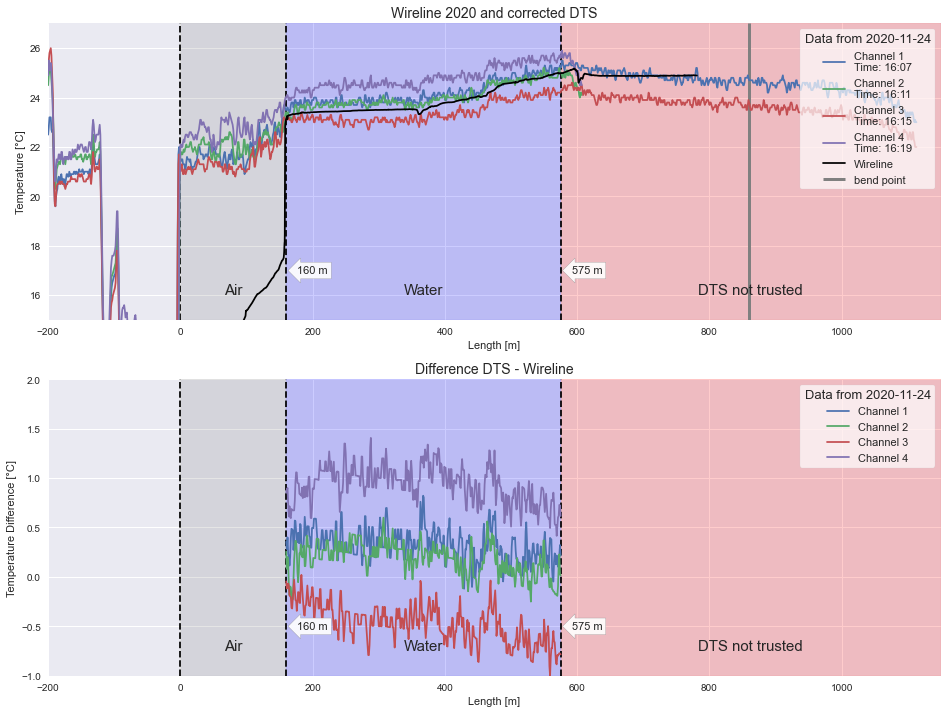

In [10]:
# compare shifted data to wireline
def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, axs, label=True):
    """ creates patches which color the plot"""
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=(ymax-ymin),color=col,alpha=0.2)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.1,label_name,ha="center",va="center",size=15,bbox=bbox_props)

begin_shaft = 200 # muss ich noch genauer nachgucken
fig, axs = plt.subplots(2,1,figsize=[16,12])

axs[0].set_title("Wireline 2020 and corrected DTS", fontsize = 14)
axs[0].set_ylabel("Temperature [°C]")
ylim=[15,27]
axs[0].set_ylim(ylim)
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_ch14_constshifted[chan].index)
    axs[0].plot(data_ch14_constshifted[chan].loc[date_name].index - begin_shaft,data_ch14_constshifted[chan].loc[date_name].values,label=f"Channel {chan}\nTime: {date_name[11:-3]}") #\nTime: {date_name[11:-3]}
axs[0].plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline",color="black")
#color plot
axs[0].vlines([0,160,575],ylim[0],ylim[1],color="black",linestyle="--")
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[0].text(575 + 40, 17,"575 m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[0].text(160 + 40, 17,"160 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(575,1150,"red",ylim[0],ylim[1],"DTS not trusted",axs[0])
color_cable_pos(0,160,"gray",ylim[0],ylim[1],"Air",axs[0])
color_cable_pos(160,575,"blue",ylim[0],ylim[1],"Water",axs[0])

# Bend point
last_length={}
for channel in ["1","2","3","4"]:
    last_length[channel] = data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[begin_shaft:]].columns.max() - begin_shaft
    #print(f"Channel {channel} shifted, last length {last_length[channel]}")
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2 #passt ziemlich genau zur Einbautiefe der Erdwärmesonde
axs[0].vlines([bend_point],ylim[0],ylim[1],color="grey",label="bend point", linewidth=3)

#####################################################################################

axs[1].set_ylabel("Temperature Difference [°C]")
axs[1].set_title("Difference DTS - Wireline", fontsize = 14)
ylim=[-1,2]
axs[1].set_ylim(ylim)
for chan in ["1","2","3","4"]:
    axs[1].plot(diff_to_wireline[chan],label=f"Channel {chan}")
#color plot
axs[1].vlines([0,160,575],ylim[0],ylim[1],color="black",linestyle="--")
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[1].text(575 + 40, -0.5,"575 m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[1].text(160 + 40, -0.5,"160 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(575,1150,"red",ylim[0],ylim[1],"DTS not trusted",axs[1])
color_cable_pos(0,160,"gray",ylim[0],ylim[1],"Air",axs[1])
color_cable_pos(160,575,"blue",ylim[0],ylim[1],"Water",axs[1])

for ax in axs:
    ax.set_xlim([-200,1150])
    ax.set_xlabel("Length [m]")
    legend = ax.legend(fontsize=11,title="Data from 2020-11-24", title_fontsize=11+2, frameon=True, loc="upper right")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")

if plot_save:
    plt.savefig("pictures\compare_wireline2020.png")
    plt.savefig("pictures\compare_wireline2020.png", dpi=720)

# Accuracy vom Temp log 0.5 - 1 °C? -- > nachfragen
# https://www.maximintegrated.com/en/design/technical-documents/app-notes/3/3892.html

## Plot Shaft Temperature

Channel 1 shifted, last length 1113
Channel 2 shifted, last length 607
Channel 3 shifted, last length 1114
Channel 4 shifted, last length 607
bend point would be at 860.0, if assuming the DTS measurements exactly stop at the fibre break
die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?


Text(0, 0.5, 'Temperature [°C]')

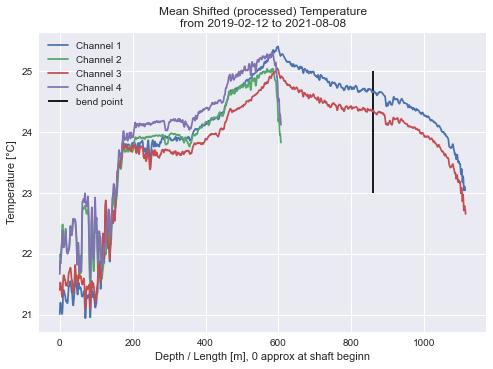

In [11]:
begin_shaft = 200
last_length={}
for channel in ["1","2","3","4"]:
    last_length[channel] = data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[begin_shaft:]].columns.max() - begin_shaft
    print(f"Channel {channel} shifted, last length {last_length[channel]}")
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2
print(f"bend point would be at {bend_point}, if assuming the DTS measurements exactly stop at the fibre break")
print("die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?")

#Plot shifted data
# shaft variable only contains the data until bottom of shaft
# for chan in ["1","2","3","4"]:
#     plt.plot(shaft[chan].mean(axis=0))
for channel in ["1","2","3","4"]:
    y=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].mean(axis=0).values
    x=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].mean(axis=0).index - 200
    plt.plot(x,y, label=f"Channel {channel}")

plt.vlines([bend_point],23,25,color="black",label="bend point")
plt.legend()
min_date=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].index.min().strftime("%Y-%m-%d")
max_date=data_ch14_constshifted[channel][data_ch14_constshifted[channel].columns[200:]].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Shifted (processed) Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth / Length [m], 0 approx at shaft beginn")
plt.ylabel("Temperature [°C]")

## Interpretation
* ist knick bei depth 600 realer Temperaturänderung im Schacht? Die kurzen Kabel gehen bis ca. 600. 
    * Dieser Knick ist also bei der selben Tiefe wo das Kabel gebrochen ist. (Aus der Sicht von Channel 1 und 3 ist es auf dem Weg hoch gebrochen). 
* Ist es nicht auch verwunderlich, dass nur zwei der 4 Fasern an der Stelle gebrochen sind? Die anderen werden auch in irgendeinareweise Schaden erlitten haben?!
* Bei ca. 860 geht das Kabel irgendwann wieder hoch, ist aber nicht zu sehen, eigentlich müsste es ja symmetrisch sein ab dem Punkt wo es wieder hochgeht.
* Das der Kabelbruch Punkte von vorher beeinflusst kann eigentlich nicht sein, da das Licht ja noch gar nicht bis zum Kabelbruch gekommen ist. Beschädigungen am Kabel können also nur Punkte die später kommen beeinflussen. Norbert meinte, dass sie auch vorher beieinflussen können muss ich in Literatur noch gucken.
* Bei ca. 0 (shaft begin) sieht man in den backscattered Daten eine Dämpfungsänderrung. Dort wurden Kabel gespleißt??????
* Bei 600 - 608 m sind bei der Kamerabefahrung Seile gefunden worden: ANh01 Fotot 18; Abschlussbericht S. 44
  * war die in der Pegelleitung oder im Schacht?

# Compare Channel 1-4 and Channel 5-8
Here I use the final corrected data for comparisson. The results should be "equal"

Text(0, 0.5, 'Temperature [°C]')

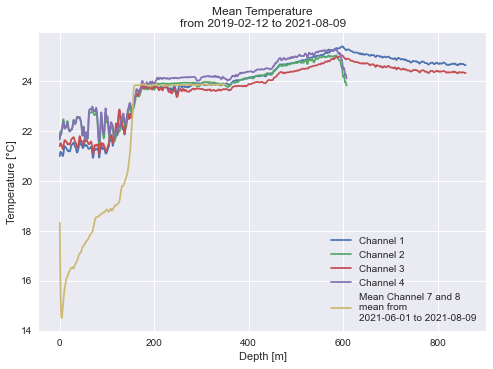

In [12]:
#both datafames have the same number of rows and dates are similar
for chan in ["1","2","3","4"]:
    plt.plot(shaft[chan].mean(axis=0).index,shaft[chan].mean(axis=0).values, label=f"Channel {chan}")

min_date=Schacht_7and8_down.index.min().strftime("%Y-%m-%d")
max_date=Schacht_7and8_down.index.max().strftime("%Y-%m-%d")
plt.plot(Schacht_7and8_down.mean(axis=0).index,Schacht_7and8_down.mean(axis=0).values, label=f"Mean Channel 7 and 8\nmean from \n{min_date} to {max_date}")
plt.legend()
min_date=shaft["2"].index.min().strftime("%Y-%m-%d")
max_date=shaft["2"].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")

In [13]:
# Calc diff to EGRT cable
channel="3"

data1 = shaft[channel]
data2 = Schacht_7and8_down
date_name, date_iloc = find_nearest_date(data2.iloc[0].name, data1.index) #find out which dates I need from data1
diff_othercable = calc_diff_between_channels(data1[date_iloc:], data2, expected_difference_minutes=15)

diff_statistic = calc_stat_of_difference(diff_othercable["diff_abs"].transpose())

# diese Berechnung könnte ich auch für jeden Channel machen, aber man sieht ja oben, dass das keinen großen Unterschied macht

# Warning später mit beschäftigen

Warning 2: large time difference
0 days 00:46:02
Warning 1: large time difference
0 days 00:18:00
Warning 1: large time difference
0 days 00:18:01


c:\Users\Mathis\Desktop\Masterarbeit\Scripts\my_func_mvw\functions.py:211: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(data_array)
C:\Users\Mathis\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [14]:
#px.imshow(diff_othercable["diff"],zmin=-2,zmax=2)

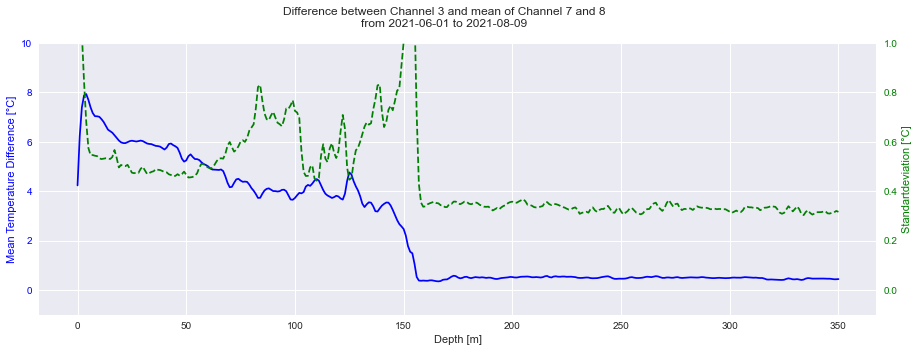

In [15]:
# Plot difference
##########Inputs##########
ymin=-1;ymax=10
cmean="blue";cstdev="green"
lstyle_mean="-";lstyle_stdev="--"
######################
fig,axs=plt.subplots(1,1,figsize=[15,5])#,constrained_layout=True)
min_date=diff_othercable["diff_abs"].columns.min().strftime("%Y-%m-%d")
max_date=diff_othercable["diff_abs"].columns.max().strftime("%Y-%m-%d")
fig.suptitle(f"Difference between Channel {channel} and mean of Channel 7 and 8\nfrom {min_date} to {max_date}")
#fig.tight_layout()

axs.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean",color=cmean,linestyle=lstyle_mean)#label="Bottom Hole Temperature"
axs.set_xlabel("Depth [m]")
axs.set_ylabel("Mean Temperature Difference [°C]",color=cmean)
axs.set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs.tick_params(axis='y', labelcolor=cmean)

axs0_2 = axs.twinx()
axs0_2.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev",color=cstdev,linestyle=lstyle_stdev) #,label="Salinity")
axs0_2.set_ylabel('Standartdeviation [°C]', color=cstdev)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cstdev)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines


* Im Wasser sind sich die Ergebnisse sehr ähnlich. Vorher nicht.
* Die ersten 151.6 m gehen Channel 1-4 durch eine Bohrung im Beton. 
* Channel 5-8 gehen die durch ein anderes Rohr, eine Pegelleitung

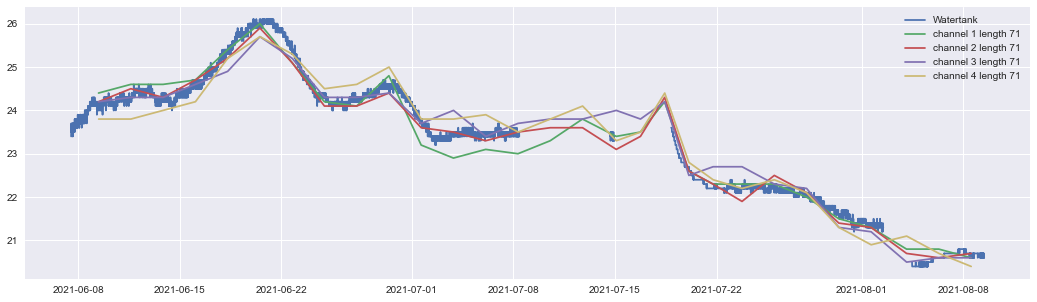

In [16]:
# Compare watertank to channels
# to find where the watertank position is
watertank = 71 

plt.figure(figsize=(18,5))
plt.plot(df_Tlogger_PT100.index, df_Tlogger_PT100["Channel1-Watertank_PT100"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_ch14_constshifted[c][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][watertank].index
    val=data_ch14_constshifted[c][str(df_Tlogger_PT100.index.min()) : str(df_Tlogger_PT100.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")

plt.legend()

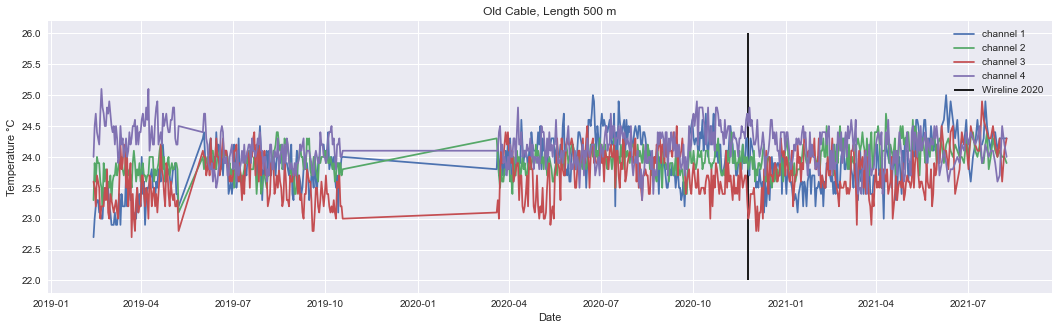

In [17]:
# plot all const shift data
# to find where the watertank position is
length = 500 

plt.figure(figsize=(18,5))

for c in ["1","2","3","4"]: 
    inde=data_ch14_constshifted[c][length].index
    val=data_ch14_constshifted[c][length].values
    plt.plot(inde,val, label=f"channel {c}")
plt.vlines(pd.to_datetime("2020-11-24 12:00:00"),22,26,color="black",label="Wireline 2020")
#plt.plot(df_Tlogger_PT100.index, df_Tlogger_PT100["Channel1-Watertank_PT100"], label="Watertank")

plt.ylabel("Temperature °C")
plt.xlabel("Date")
plt.title(f"Old Cable, Length {length} m")
plt.legend()

# temperatur Stadium des Wireline logs unterscheided sich um einige Grad vom aktuellen Stadium indem es Wassertank temperaturen gibt